### 분석에 필요한 패키지 Import

In [3]:
# 다음 코드의 주석을 해제하고 패키지를 설치해주세요.
!pip install xgboost lightgbm catboost scikit-learn --quiet

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

SEED = 42 # random state 통일

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import (
    VotingClassifier,
    RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, StackingClassifier
)
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

### 데이터 로드

In [7]:
# df라는 변수에 'Employee.csv' 파일을 읽어와 저장합니다.
df = pd.read_csv('Employee.csv')

In [ ]:
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [ ]:
target = 'LeaveOrNot'

In [ ]:
X = df.drop(columns=[target]) # target 컬럼을 제외한 데이터를 X에 저장합니다.
y = df[target]

### 데이터 전처리

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 290.9+ KB


In [ ]:
X.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain
0,Bachelors,2017,Bangalore,3,34,Male,No,0
1,Bachelors,2013,Pune,1,28,Female,No,3
2,Bachelors,2014,New Delhi,3,38,Female,No,2
3,Masters,2016,Bangalore,3,27,Male,No,5
4,Masters,2017,Pune,3,24,Male,Yes,2


In [ ]:
# 범주형 변수 전처리
# 일괄적으로 인코딩을 진행하겠습니다.

cat_cols = [
    'Education',
    'City',
    'Gender',
    'EverBenched'
]

for col in cat_cols:
    le = LabelEncoder()

    # 각 범주형 변수(col)에 대해 인코딩을 수행합니다.
    X[col] = le.fit_transform(X[col].astype(str))

In [ ]:
# 스케일링

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### 훈련용 / 테스트용 데이터 분할

In [ ]:
# X_scaled와 y를 훈련용과 테스트용 데이터로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=SEED
)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3722, 8)
(3722,)
(931, 8)
(931,)


## 모델링

주어진 데이터셋에 대해 단일 모델과 앙상블 기법을 각각 적용해보고 결과를 비교해봅시다.

### 단일 모델 적용

앙상블 기법을 적용하기 전에, 이전에 배웠던 단일 분류 모델들을 적용해봅시다!

(분류 기초 세션 복습 🤓)

#### 1. Logistic Regression

In [ ]:
# 모델을 불러와 훈련시킵니다.
lr = LogisticRegression(random_state=SEED)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [ ]:
# 모델을 통해 예측을 수행합니다.
y_lr_pred = lr.predict(X_test)

In [ ]:
# 계산된 예측값에 대해 정확도를 계산합니다.
lr_accuracy = accuracy_score(y_test, y_lr_pred)
lr_report = classification_report(y_test, y_lr_pred)

print(f"Accuracy score : {lr_accuracy}")
print(f"Report :\n{lr_report}")

Accuracy score : 0.7110633727175081
Report :
              precision    recall  f1-score   support

           0       0.73      0.88      0.80       610
           1       0.63      0.39      0.48       321

    accuracy                           0.71       931
   macro avg       0.68      0.64      0.64       931
weighted avg       0.70      0.71      0.69       931



#### 2. 의사결정나무

In [ ]:
tree = DecisionTreeClassifier(random_state=SEED)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
y_tree_pred = tree.predict(X_test)

In [ ]:
tree_accuracy = accuracy_score(y_test, y_tree_pred)
tree_report = classification_report(y_test, y_tree_pred)

print(f"Accuracy score : {tree_accuracy}")
print(f"Report :\n{tree_report}")

Accuracy score : 0.8367346938775511
Report :
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       610
           1       0.78      0.73      0.75       321

    accuracy                           0.84       931
   macro avg       0.82      0.81      0.82       931
weighted avg       0.83      0.84      0.84       931



#### 3. SVM

In [ ]:
svm = SVC(random_state=SEED)
svm.fit(X_train, y_train)

SVC(random_state=42)

In [ ]:
y_svm_pred = svm.predict(X_test)

In [ ]:
svm_accuracy = accuracy_score(y_test, y_svm_pred)
svm_report = classification_report(y_test, y_svm_pred)

print(f"Accuracy score : {svm_accuracy}")
print(f"Report :\n{svm_report}")

Accuracy score : 0.8592910848549946
Report :
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       610
           1       0.93      0.64      0.76       321

    accuracy                           0.86       931
   macro avg       0.88      0.81      0.83       931
weighted avg       0.87      0.86      0.85       931



#### 4. kNN

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_knn_pred = knn.predict(X_test)

In [ ]:
knn_accuracy = accuracy_score(y_test, y_knn_pred)
knn_report = classification_report(y_test, y_knn_pred)

print(f"Accuracy score : {knn_accuracy}")
print(f"Report :\n{knn_report}")

Accuracy score : 0.8281417830290011
Report :
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       610
           1       0.82      0.64      0.72       321

    accuracy                           0.83       931
   macro avg       0.83      0.78      0.80       931
weighted avg       0.83      0.83      0.82       931



#### 네 가지 단일 모델의 결과 비교

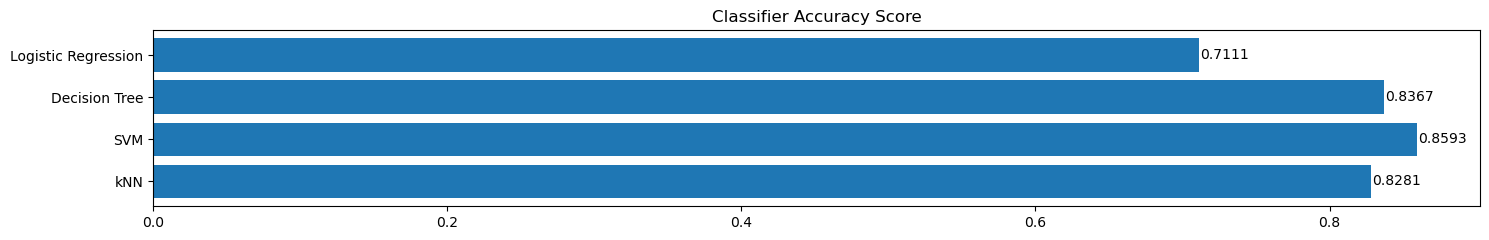

In [ ]:
model_name = ['Logistic Regression', 'Decision Tree', 'SVM', 'kNN']
accuracy_scores = [lr_accuracy, tree_accuracy, svm_accuracy, knn_accuracy]

plt.figure(figsize=(15, 2.5))
bars = plt.barh(model_name[::-1], accuracy_scores[::-1])

for bar, accuracy in zip(bars, accuracy_scores[::-1]):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height() / 2, f'{accuracy:.4f}', va='center')

plt.title("Classifier Accuracy Score")
plt.xlabel("")
plt.tight_layout()
plt.show()

## 앙상블 (Ensemble)

### 1. Voting

`VotingClassifier`

- **estimators**: 사용할 기본 분류기 리스트 (이름, 모델) 형태로 지정
- **voting**: 'hard' 또는 'soft' (기본값: 'hard')
- **weights**: 각 분류기별 가중치
- **n_jobs**: 병렬 처리 수

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

In [ ]:
# estimators 인자로 들어갈 분류기 리스트를 지정합니다.
models = [
    ('lr', LogisticRegression(random_state=SEED)), 
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
]

In [ ]:
# 모델 생성
# estimators는 models로, voting은 'hard'로 설정합니다.
voting_clf = VotingClassifier(
    estimators=models, 
    voting='hard'
)

# 모델 훈련
voting_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_voting_pred = voting_clf.predict(X_test)

# 정확도 출력
print(f"Voting Accuracy: {accuracy_score(y_test, y_voting_pred):.4f}")

Voting Accuracy: 0.8507


### 2. Bagging

`RandomForestClassifier`

- **n_estimators**: 트리 개수
- **max_depth**: 트리 최대 깊이
- **max_features**: 노드 분할 시 고려할 특성 수
- **min_samples_split**: 노드 분할에 필요한 최소 샘플 수
- **bootstrap**: 부트스트랩 여부 (기본값: True)

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [ ]:
# 모델 생성
rf_clf = RandomForestClassifier(random_state=SEED)

# 모델 훈련
rf_clf.fit(X_train, y_train) 

# 테스트 데이터에 대한 예측 수행
y_rf_pred = rf_clf.predict(X_test)

# 정확도 출력
print(f"Bagging (Random Forest) Accuracy: {accuracy_score(y_test, y_rf_pred):.4f}")

Bagging (Random Forest) Accuracy: 0.8496


### 3. Boosting

#### 3.1 AdaBoost

`AdaBoostClassifier`

- **estimator**: 기본 약한 학습기
- **n_estimators**: 학습기 개수
- **learning_rate**: 학습률

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [ ]:
# 모델 생성
adaboost = AdaBoostClassifier(random_state=SEED)

# 모델 훈련
adaboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_ada_pred = adaboost.predict(X_test)

# 정확도 출력
print(f"AdaBoost Accuracy: {accuracy_score(y_test, y_ada_pred):.4f}")

AdaBoost Accuracy: 0.8142


#### 3.2 GBM

`GradientBoostingClassifier`

- **n_estimators**: 부스팅 단계 수
- **learning_rate**: 각 단계의 기여도
- **max_depth**: 개별 트리의 최대 깊이
- **subsample**: 학습 데이터 샘플 비율
- **min_samples_split**: 노드 분할 최소 샘플 수
- **loss**: 손실 함수 ('log_loss', 'exponential')

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [ ]:
# 모델 생성
gbm = GradientBoostingClassifier(random_state=SEED)

# 모델 훈련
gbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_gbm_pred = gbm.predict(X_test)

# 정확도 출력
print(f"GBM Accuracy: {accuracy_score(y_test, y_gbm_pred):.4f}")

GBM Accuracy: 0.8604


#### 3.3 XGBoost

`XGBClassifier`

- **n_estimators**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **max_depth**: 트리 깊이
- **subsample**: 샘플 비율
- **colsample_bytree**: 트리당 특성 샘플 비율
- **gamma**: 분할 최소 손실 감소
- **objective**: 목적 함수 ('multi:softprob', 'binary:logistic' 등)
- **eval_metric**: 평가 지표 ('mlogloss', 'logloss', 'error' 등)

[Docs](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)

In [ ]:
# 모델 생성
xgboost = xgb.XGBClassifier(random_state=SEED)

# 모델 훈련
xgboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_xgb_pred = xgboost.predict(X_test)

# 정확도 출력
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_xgb_pred):.4f}")

XGBoost Accuracy: 0.8582


#### 3.4 LightGBM

`LGBMClassifier`

- **n_estimators**: 트리 개수
- **learning_rate**: 학습률
- **max_depth**: 최대 깊이 (기본: -1 → 제한 없음)
- **num_leaves**: 리프 노드 수
- **subsample**: 데이터 샘플 비율
- **colsample_bytree**: 트리당 특성 샘플 비율
- **min_child_samples**: 리프 노드의 최소 샘플 수
- **objective**: 'binary', 'multiclass' 등

[Docs](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [ ]:
# 모델 생성 (LGBMClassifier)
lgbm = lgb.LGBMClassifier(random_state=SEED, verbose=-1)

# 모델 훈련
lgbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_lgbm_pred = lgbm.predict(X_test)

# 정확도 출력
print(f"LightGBM Accuracy: {accuracy_score(y_test, y_lgbm_pred):.4f}")

LightGBM Accuracy: 0.8496


#### 3.5 CatBoost

`CatBoostClassifier`

- **iterations**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **depth**: 트리 깊이
- **l2_leaf_reg**: L2 정규화 계수
- **loss_function**: 손실 함수 (예: 'Logloss', 'MultiClass')
- **random_state**: 랜덤 시드
- **verbose**: 출력 제어 (0: 진행 메시지 표시하지 않음, 100: 진행률 표시)

[Docs](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier)

In [ ]:
# 모델 생성
cb = CatBoostClassifier(random_state=SEED, depth=10, verbose=0)

# 모델 훈련
cb.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_cb_pred = cb.predict(X_test)

# 정확도 출력
print(f"CatBoost Accuracy: {accuracy_score(y_test, y_cb_pred):.4f}")

CatBoost Accuracy: 0.8593


### 4. Stacking

`StackingClassifier`

- **estimators**: 기본 모델 목록 (이름, 모델) 쌍의 리스트
- **final_estimator**: 최종 분류기 (기본값: LogisticRegression)
- **cv**: 교차 검증 폴드 수 (기본값: 5)
- **passthrough**: 원본 특성을 메타 모델에 전달 여부 (기본값: False)
- **n_jobs**: 병렬 처리 수

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

In [ ]:
base_learners = [
    ('lr', LogisticRegression(random_state=SEED)),
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
]

stack_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(random_state=SEED), # 최종 분류기를 LogisticRegression(random_state=SEED) 로 지정해주세요
    cv=5
)

# 모델 훈련
stack_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_stk_pred = stack_clf.predict(X_test)

# 정확도 출력
print(f"Stacking Accuracy: {accuracy_score(y_test, y_stk_pred):.4f}")

Stacking Accuracy: 0.8582


## [과제] 모델 성능을 높여봅시다!

이제 직접 다른 전처리 기법, 피쳐 엔지니어링, 앙상블 기법, 추가 하이퍼파라미터 튜닝 등등.. 을 수행해서 더 높은 정확도를 가지는 모델을 만들어보세요.\
다양한 방법을 수행해보고, 비교한 후 결과를 정리해서 마크다운으로 남겨주시면 되겠습니다! 이때 각 단계별로 어떤 방법을 수행했는지에 대한 설명을 꼭 달아주세요.

- 정확도는 소수점 자릿수 제한 없이 모두 출력합니다.

### 1. 데이터 전처리

In [8]:
df.isnull().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

데이터셋 자체에 결측치는 존재하지 않습니다.

In [9]:
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


이번에도 똑같이 LeaveOrNot을 목표로 하여 모델링을 해보겠습니다.

In [10]:
target = 'LeaveOrNot'

In [11]:
X = df.drop(columns=[target]) # target 컬럼을 제외한 데이터를 X에 저장합니다.
y = df[target]

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 290.9+ KB


In [13]:
X['Education'].value_counts()

Education
Bachelors    3601
Masters       873
PHD           179
Name: count, dtype: int64

In [14]:
X['City'].value_counts()

City
Bangalore    2228
Pune         1268
New Delhi    1157
Name: count, dtype: int64

범주형 변수 중 하나인 `Education`과 `City`는 둘다 3종류의 값을 가지고 있습니다.\
이 두 피처는 One-Hot Encoding을, 나머지 범주형 변수들은 Label Encoding을 활용하겠습니다.

In [15]:
# Label Encoding: Gender, EverBenched
label_cols = ['Gender', 'EverBenched']
label_encoders = {}

for col in label_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # 나중에 역변환용

# One-Hot Encoding: Education, City 
X = pd.get_dummies(X, columns=['Education'])
X = pd.get_dummies(X, columns=['City'])

# 결과 확인
X.head()

,JoiningYear,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,Education_Bachelors,Education_Masters,Education_PHD,City_Bangalore,City_New Delhi,City_Pune
0,2017,3,34,1,0,0,True,False,False,True,False,False
1,2013,1,28,0,0,3,True,False,False,False,False,True
2,2014,3,38,0,0,2,True,False,False,False,True,False
3,2016,3,27,1,0,5,False,True,False,True,False,False
4,2017,3,24,1,1,2,False,True,False,False,False,True


나머지 변수들은 스케일링해주겠습니다.

In [16]:
numeric_cols = ['JoiningYear', 'PaymentTier', 'Age', 'ExperienceInCurrentDomain']
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

In [17]:
X.head()

,JoiningYear,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,Education_Bachelors,Education_Masters,Education_PHD,City_Bangalore,City_New Delhi,City_Pune
0,1.039638,0.537503,0.954645,1,0,-1.864901,True,False,False,True,False,False
1,-1.107233,-3.025177,-0.288732,0,0,0.060554,True,False,False,False,False,True
2,-0.570515,0.537503,1.783563,0,0,-0.581264,True,False,False,False,True,False
3,0.502921,0.537503,-0.495961,1,0,1.344191,False,True,False,True,False,False
4,1.039638,0.537503,-1.117650,1,1,-0.581264,False,True,False,False,False,True


In [18]:
# X와 y를 훈련용과 테스트용 데이터로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED
)

In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3722, 12)
(3722,)
(931, 12)
(931,)


### 2. 모델링

XGBoost와 CatBoost 두 가지를 활용하여, 서로 비교해보기로 하였습니다.

XGBoost는 별도 전처리를 필요로 하고, CatBoost는 필요로 하지 않는데,\
원-핫 인코딩을 해둔 상태에서는 두 모델이 얼마나 차이가 날지 궁금했습니다.

우선 XGBoost입니다.

In [ ]:
# 모델 생성
xgboost = xgb.XGBClassifier(random_state=SEED)

# 모델 훈련
xgboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_xgb_pred = xgboost.predict(X_test)

# 정확도 출력
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_xgb_pred):f}")

XGBoost Accuracy: 0.864662


하이퍼파라미터 튜닝을 진행하여 성능 개선을 노려보겠습니다.

하이퍼파라미터 최적화는 예전 6차 교육세션에서 짧게 언급하고 넘어간 `Optuna`를 사용해 보겠습니다.

`XGBClassifier`

- **n_estimators**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **max_depth**: 트리 깊이
- **subsample**: 샘플 비율
- **colsample_bytree**: 트리당 특성 샘플 비율
- **gamma**: 분할 최소 손실 감소
- **objective**: 목적 함수 ('multi:softprob', 'binary:logistic' 등)
- **eval_metric**: 평가 지표 ('mlogloss', 'logloss', 'error' 등)

In [ ]:
import optuna

# objective 함수 정의
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

# 튜닝 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# 최적 파라미터 출력
print("Best Trial:")
print(f"  Accuracy: {study.best_value:f}")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

[I 2025-05-07 19:33:21,075] A new study created in memory with name: no-name-c2914b98-2d78-408a-9eb8-9efcb45c7975
[I 2025-05-07 19:33:21,662] Trial 0 finished with value: 0.8700322234156821 and parameters: {'n_estimators': 193, 'learning_rate': 0.019728368377585865, 'max_depth': 7, 'subsample': 0.5817662422184193, 'colsample_bytree': 0.8761124268523766, 'gamma': 4.29333366834859}. Best is trial 0 with value: 0.8700322234156821.
[I 2025-05-07 19:33:22,001] Trial 1 finished with value: 0.874328678839957 and parameters: {'n_estimators': 299, 'learning_rate': 0.2972054014071586, 'max_depth': 10, 'subsample': 0.696550799535052, 'colsample_bytree': 0.6514234570933815, 'gamma': 3.6895041641599136}. Best is trial 1 with value: 0.874328678839957.
[I 2025-05-07 19:33:22,349] Trial 2 finished with value: 0.8796992481203008 and parameters: {'n_estimators': 120, 'learning_rate': 0.23107352931616484, 'max_depth': 8, 'subsample': 0.6334583815950383, 'colsample_bytree': 0.8034666468650997, 'gamma': 1.

Best Trial:
  Accuracy: 0.885070
    n_estimators: 236
    learning_rate: 0.10276108645231939
    max_depth: 10
    subsample: 0.5309977477709386
    colsample_bytree: 0.7945155164494915
    gamma: 2.677373409713088


In [ ]:
import optuna.visualization as vis

vis.plot_optimization_history(study).show()

정규화를 하이퍼 파라미터에 추가해보겠습니다:\
`'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0)`\
`'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0)`

In [ ]:
# objective 함수 정의
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'random_state': 42
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

# 튜닝 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# 최적 파라미터 출력
print("Best Trial:")
print(f"  Accuracy: {study.best_value:f}")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

[I 2025-05-07 19:52:59,626] A new study created in memory with name: no-name-49e2b5c8-ad74-4b0f-b983-22495cb921e8
[I 2025-05-07 19:52:59,962] Trial 0 finished with value: 0.8721804511278195 and parameters: {'n_estimators': 229, 'learning_rate': 0.2914729162071837, 'max_depth': 5, 'subsample': 0.6521013015792742, 'colsample_bytree': 0.773343003591081, 'gamma': 2.443078646532388, 'reg_alpha': 2.4602278242406723, 'reg_lambda': 4.477687103954564}. Best is trial 0 with value: 0.8721804511278195.
[I 2025-05-07 19:53:00,210] Trial 1 finished with value: 0.8356605800214822 and parameters: {'n_estimators': 102, 'learning_rate': 0.02008673819644594, 'max_depth': 8, 'subsample': 0.7018491994848647, 'colsample_bytree': 0.5388586109358283, 'gamma': 4.09618847657229, 'reg_alpha': 3.6856456189423965, 'reg_lambda': 2.3173616333533005}. Best is trial 0 with value: 0.8721804511278195.
[I 2025-05-07 19:53:00,394] Trial 2 finished with value: 0.8657357679914071 and parameters: {'n_estimators': 128, 'learn

Best Trial:
  Accuracy: 0.883996
    n_estimators: 232
    learning_rate: 0.048501659774206535
    max_depth: 9
    subsample: 0.671485044061537
    colsample_bytree: 0.5812122428990367
    gamma: 0.4250860231596613
    reg_alpha: 1.7524954977014642
    reg_lambda: 2.6725598458066906


최적화 결과가 더 크게 개선되지는 않을 것 같아, 여기서 마무리하겠습니다\
전처리 > XGB > Optuna (하이퍼파라미터 튜닝)\
결과: XGBoost Accuracy: 0.864662 → **0.885070**

이번에는 CatBoost입니다.

전처리한 데이터는 그대로 사용하되 우선 모델을 돌려보겠습니다.

In [ ]:
# 모델 생성
cb = CatBoostClassifier(random_state=SEED, depth=10, verbose=0)

# 모델 훈련
cb.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_cb_pred = cb.predict(X_test)

# 정확도 출력
print(f"CatBoost Accuracy: {accuracy_score(y_test, y_cb_pred):f}")

CatBoost Accuracy: 0.863588


동일하게 `Optuna`를 통하여 하이퍼 파라미터 튜닝을 진행하겠습니다.

`CatBoostClassifier`

- **iterations**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **depth**: 트리 깊이
- **l2_leaf_reg**: L2 정규화 계수
- **loss_function**: 손실 함수 (예: 'Logloss', 'MultiClass')
- **random_state**: 랜덤 시드
- **verbose**: 출력 제어 (0: 진행 메시지 표시하지 않음, 100: 진행률 표시)

In [21]:
import optuna

# objective 함수 정의
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_state': 42,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    # 선택 기준 변경 가능: accuracy_score → f1_score(y_test, preds)
    return accuracy_score(y_test, preds)

# 튜닝 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# 최적 하이퍼파라미터 출력
print("Best Trial:")
print(f"  Accuracy: {study.best_value:f}")
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

[I 2025-05-07 20:40:23,396] A new study created in memory with name: no-name-33282af4-a833-4107-bdeb-dec425d0b0f1
[I 2025-05-07 20:40:26,000] Trial 0 finished with value: 0.8754027926960258 and parameters: {'iterations': 348, 'learning_rate': 0.017448422956061794, 'depth': 8, 'l2_leaf_reg': 5.906263151766542, 'border_count': 230}. Best is trial 0 with value: 0.8754027926960258.
[I 2025-05-07 20:40:27,711] Trial 1 finished with value: 0.8711063372717508 and parameters: {'iterations': 145, 'learning_rate': 0.12528835913053646, 'depth': 10, 'l2_leaf_reg': 7.824574624340393, 'border_count': 71}. Best is trial 0 with value: 0.8754027926960258.
[I 2025-05-07 20:40:28,963] Trial 2 finished with value: 0.8721804511278195 and parameters: {'iterations': 237, 'learning_rate': 0.02763000648429283, 'depth': 7, 'l2_leaf_reg': 3.8458284755536285, 'border_count': 240}. Best is trial 0 with value: 0.8754027926960258.
[I 2025-05-07 20:40:30,887] Trial 3 finished with value: 0.8721804511278195 and parame

Best Trial:
  Accuracy: 0.881847
  Params:
    iterations: 394
    learning_rate: 0.020164430548401176
    depth: 6
    l2_leaf_reg: 4.290298215010786
    border_count: 177


*XGBoost는 500번 시도에도 실행 시간이 오래 걸리지 않았지만, 동일하게 500번 시도한 CatBoost는 약 15분이 소요되었습니다.*\
*GPU 성능에 따라 실행 시간에 편차가 있다고 하니, 제 컴퓨터가 구형이라 그 영향이 있었던 것 같습니다. 추후에는 Google Colab과 같은 환경을 활용해 실행하는 방안을 고려해야겠습니다.*

In [23]:
import optuna.visualization as vis

vis.plot_optimization_history(study).show()

최적화 결과가 더 크게 개선되지는 않을 것 같아, 여기서 마무리하겠습니다\
전처리 > CatBoost > Optuna (하이퍼파라미터 튜닝)\
결과: CatBoost Accuracy: 0.863588 → **0.881847**

XGBoost Accuracy: 0.864662 → **0.885070**\
CatBoost Accuracy: 0.863588 → **0.881847**

XGBoost가 하이퍼 파라미터 튜닝을 진행하였을 때, 더 좋은 결과값을 출력하였습니다.\
굳이 필요하지 않은 전처리를 진행했던 까닭일까요? CatBoost는 XGBoost 대비 아쉬운 결과를 보였는데요.

실제로 GPT에게 물어본 결과, 원-핫 인코딩이 잘 진행되었다면, 더 좋은 결과값을 보일 수 있다고 합니다.

> 이처럼 범주형 변수가 3가지 정도로 적을 경우에는 원-핫 인코딩 후 XGBoost를 사용하는 것이 효율적이며, 반대로 범주형 변수가 많아 원-핫 인코딩이 부담스러운 경우에는 CatBoost를 사용하는 것이 더 적합하다는 결론을 실전적으로 도출할 수 있었습니다.